simulacion de dia de trabajo de plataforma, el objetivo es simular un dia de requerimientos en la plataforma 
y poder manipular los requerimientos de entrada de tal manera que la carga de trabajo sea lo mas distribuida
y uniforme posible para los minutos del dia en la plataforma

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from tqdm import tqdm
import math

In [5]:
def rango(df):
    ran = []
    for (index, fila) in df.iterrows():
        cont = 0
        fin = 0 
        for m in fila.values:
            cont+=1
            if(m == 1):
                ini = cont
                cont = 0
                break
        for m in reversed(fila.values):
            cont+=1
            if(m == 1):
                fin = 1441 - cont 
                cont = 0
                break
        if((fin - ini) == 0): # evitamos rango 0 en registros unicos por dia 
            ran.append(1)
            
        else:
            ran.append(fin - ini)
    
    df['rango_min'] = ran
    del ran

In [6]:
# para encotrar primer minuto de aparicion 
def aparicion(df):
    lista_apariciones = []
    for (index, fila) in df.iterrows():
        cont = 0
        for m in fila.values:
            cont+=1
            if(m >= 1):
                lista_apariciones.append(cont)
                break
    df.insert(loc=0, column='FirstTime', value=lista_apariciones)#modificacion para uso en simuladoe 2 
    #f['FirstTime'] = lista_apariciones
    del lista_apariciones

In [6]:
def preproceso(df):
    tipo = df["Trigger"].to_numpy()
    df.drop(['HashOwner', 'HashApp', 'Trigger'], axis = 1, inplace = True)
    df.set_index('HashFunction',inplace=True) # para hacer sencillo el reemplazo de # de invocaciones por minuto 
    df=df.where(df <= 1, 1)                 # si se invocó 12veces en un minuto se reeplaza a 1 para analizar periodicidad 
    invocaciones = pd.Series(df.iloc[:, 0:].sum(axis=1)) # llevamos conteo de # de aparicicones en el dia de una funcion
    rango(df)
    df["ivocationDay"] = invocaciones
    df["periodo"] = df.apply(lambda x: 1440 if (x["ivocationDay"]==1) else (x["rango_min"]/(x["ivocationDay"]-1)) , axis = 1) 
    df["periodo"] = df["periodo"].round(2)
    period = df["periodo"].to_numpy()
    df.drop(['periodo', 'rango_min'], axis=1, inplace=True)
    aparicion(df)
    df["period"] = period
    df["Trigger"] = tipo
    df['HashFunction'] = df.index
    df.reset_index(drop = True, inplace = True)
    df = df[['HashFunction','Trigger','period', 'FirstTime']]

    return df # def con HashFuntion como index

In [4]:
# funcion para generar 
def period_list(period, inic):
    l=[1 if x % period == 0 else 0 for x in range(1,1441)] 
    l2 = [0 for x in range(1,abs(period-inic)+1)]
    if((period == 1) or (inic > period)):
        l = l2+l        
        return l[:1440]
    else:
        l = l+l2
        del l[0:abs(period-inic)]
        return l

In [250]:
carga = pd.read_csv("invocations_per_function_md.anon.d05.csv")

In [9]:
dia = preproceso(carga)
dia

HashFunction        Trigger  \
0      520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96...           http   
1      115ca7a2b5bc290052c3da74cd0347d19c3c67b7d5aa66...           http   
2      fa4f840d0cddc391a9afee2b15074f7f92bec15e7ea916...          queue   
3      93e6c664773bbec3a7f50a0e92fa7e97401a802dc6eed8...  orchestration   
4      740c5c767e4b9978ee59a97d1829cfbaf755a47806a311...           http   
...                                                  ...            ...   
46652  d01feeef6c6a03ba8cc96dbfdcb8898106b18acbe9d100...           http   
46653  d43df62e0448cf994831aba36a262443378c03993bbb7b...           http   
46654  f1ff5a83374938d5da346b909ae4c6aaf6488f575116c9...           http   
46655  d6a50fa610274244b42a39dcb31f28a699dc289ce5e782...           http   
46656  3d8e7e07d617138e120d85a3d46013ff848fe5e34fcc4a...           http   

        period  FirstTime  
0         5.00          1  
1         5.00          3  
2       140.00        101  
3        66.95         98  
4        70.61         98  
...        ...        ...  
46652   720.00        679  
46653    69.53        170  
46654  1440.00        679  
46655   147.75        169  
46656  1440.00        172  

[46657 rows x 4 columns]

In [265]:
#dia['FirstTime'].plot.hist(bins = 1438, figsize=(15,5), ylim=(0,2000))
def simulation(df_day):
    record = [0 for x in range(1,1441)]
    overl_minutes = []
    columns = [x for x in range(1,1441)]
    columns.insert(0,"HashFunction")
    df_result = pd.DataFrame(columns=columns)
    with tqdm(total=len(df_day), file=sys.stdout) as pbar:
        for row in df_day.itertuples(): 
            ini = row.FirstTime
            t_period = period_list(int(row.period), int(ini))
            record = np.add(record,t_period)
            overl_minutes = [i+1 for i, v in enumerate(record) if v > 60] # minutos que pasan el lim 

            if ini in overl_minutes:
                while ini in overl_minutes:
                    
                    record = np.subtract(record,t_period)
                    overl_minutes = [i+1 for i, v in enumerate(record) if v > 60]
                    
                    ini+=1
                    t_period = period_list(int(row.period), int(ini))
                   
                    record = np.add(record,t_period)
                    overl_minutes = [i+1 for i, v in enumerate(record) if v > 60]
                    

            t_period.insert(0,row.HashFunction)
            df_result= df_result.append(pd.DataFrame([t_period], columns=columns),ignore_index=True)
            pbar.set_description('procesando')
            pbar.update(1)
    return df_result
#error,pregunta por un numero de inicio cuando puedo tener mas del limite en min 1 y preguntar por min 2
#solucion, preguntar cuales de los numeros pasan el limite y si el nuevo esta en esa lista aumentar en 1 o 2
#hasta que no este en esa lista 
    

In [241]:
df_mod = simulation(dia)

procesando:   5%|███▎                                                           | 2451/46657 [05:22<1:37:00,  7.59it/s]


KeyboardInterrupt: 

In [238]:
dia.groupby('FirstTime').count()

HashFunction  Trigger  period
FirstTime                               
1                 16205    16205   16205
2                  1035     1035    1035
3                   543      543     543
4                   447      447     447
5                   397      397     397
...                 ...      ...     ...
1435                  2        2       2
1436                 10       10      10
1437                  4        4       4
1439                  8        8       8
1440                 41       41      41

[1412 rows x 3 columns]

In [242]:
dia.iloc[:5000, :]

HashFunction        Trigger  \
0     520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96...           http   
1     115ca7a2b5bc290052c3da74cd0347d19c3c67b7d5aa66...           http   
2     fa4f840d0cddc391a9afee2b15074f7f92bec15e7ea916...          queue   
3     93e6c664773bbec3a7f50a0e92fa7e97401a802dc6eed8...  orchestration   
4     740c5c767e4b9978ee59a97d1829cfbaf755a47806a311...           http   
...                                                 ...            ...   
4995  03a8ce97ec9aa00fd8d6d24eab523494dd03c9fb3cf176...           http   
4996  644fccc5b453b55d8b8dc0e23685ed0d1994e02abf2635...           http   
4997  3ed238514ef98de7bbd3bf25708ac301b2adf1862ade1f...          event   
4998  c78572fe97975dd982529cead61e27c38ea3a0b2b5dc8f...          timer   
4999  33dd186d73b1184507c0f26915ad656531202b1a33cee9...           http   

      period  FirstTime  
0       5.00          1  
1       5.00          3  
2     140.00        101  
3      66.95         98  
4      70.61         98  
...      ...        ...  
4995   60.00        245  
4996    5.47        332  
4997    1.00          1  
4998    1.01          1  
4999  207.67        387  

[5000 rows x 4 columns]

In [246]:
dia.iloc[:3000, :].groupby('FirstTime').count()

HashFunction  Trigger  period
FirstTime                               
1                  1058     1058    1058
2                    70       70      70
3                    40       40      40
4                    24       24      24
5                    30       30      30
...                 ...      ...     ...
1399                  1        1       1
1401                  1        1       1
1413                  1        1       1
1431                  2        2       2
1440                  2        2       2

[666 rows x 3 columns]

In [ ]:
df_mod = simulation(dia.iloc[:3000, :])


In [266]:
### prueba corta 
carga = pd.read_csv("invocations_per_function_md.anon.d05.csv")
carga
miniDia = carga.iloc[:3000, :]
mDia = preproceso(miniDia)
DiaMod = simulation(mDia) 

C:\Users\robin\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


procesando: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [1:31:00<00:00,  1.82s/it]


In [269]:
miniDia

1  2  3  4  5  6  7  8  9  \
HashFunction                                                                    
520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96b...  1  0  0  0  0  1  0  0  0   
115ca7a2b5bc290052c3da74cd0347d19c3c67b7d5aa66e...  0  0  1  0  0  0  0  1  0   
fa4f840d0cddc391a9afee2b15074f7f92bec15e7ea9164...  0  0  0  0  0  0  0  0  0   
93e6c664773bbec3a7f50a0e92fa7e97401a802dc6eed86...  0  0  0  0  0  0  0  0  0   
740c5c767e4b9978ee59a97d1829cfbaf755a47806a3114...  0  0  0  0  0  0  0  0  0   
...                                                .. .. .. .. .. .. .. .. ..   
4ea471ff7d1d8db9dc42d104d83ddc968e650b8b4361115...  0  0  0  0  0  0  0  0  0   
b338122041b155a460f99d4a497ec9a95a4d3ee3f9e90e3...  0  0  0  0  0  0  0  0  0   
9fe5f0f556aca64d30d4f1287d477a9318a46abe1c43714...  0  0  0  0  0  0  0  0  0   
d032961a9a9325d54f6f67a70cf0082b9b147c434f816a3...  0  0  0  0  0  0  0  0  0   
0691cf2b03ca11b9cf0685a65dca4dd82a4647707698128...  0  0  0  0  0  0  0  0  0   

                                                    10  ...  1431  1432  1433  \
HashFunction                                            ...                     
520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96b...   0  ...     1     0     0   
115ca7a2b5bc290052c3da74cd0347d19c3c67b7d5aa66e...   0  ...     0     0     1   
fa4f840d0cddc391a9afee2b15074f7f92bec15e7ea9164...   0  ...     0     0     0   
93e6c664773bbec3a7f50a0e92fa7e97401a802dc6eed86...   0  ...     0     0     0   
740c5c767e4b9978ee59a97d1829cfbaf755a47806a3114...   0  ...     0     0     0   
...                                                 ..  ...   ...   ...   ...   
4ea471ff7d1d8db9dc42d104d83ddc968e650b8b4361115...   0  ...     0     0     0   
b338122041b155a460f99d4a497ec9a95a4d3ee3f9e90e3...   0  ...     0     0     0   
9fe5f0f556aca64d30d4f1287d477a9318a46abe1c43714...   0  ...     0     0     0   
d032961a9a9325d54f6f67a70cf0082b9b147c434f816a3...   0  ...     0     0     0   
0691cf2b03ca11b9cf0685a65dca4dd82a4647707698128...   0  ...     0     0     0   

                                                    1434  1435  1436  1437  \
HashFunction                                                                 
520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96b...     0     0     1     0   
115ca7a2b5bc290052c3da74cd0347d19c3c67b7d5aa66e...     0     0     0     0   
fa4f840d0cddc391a9afee2b15074f7f92bec15e7ea9164...     0     0     0     0   
93e6c664773bbec3a7f50a0e92fa7e97401a802dc6eed86...     0     0     0     0   
740c5c767e4b9978ee59a97d1829cfbaf755a47806a3114...     0     0     0     0   
...                                                  ...   ...   ...   ...   
4ea471ff7d1d8db9dc42d104d83ddc968e650b8b4361115...     0     0     0     0   
b338122041b155a460f99d4a497ec9a95a4d3ee3f9e90e3...     0     0     0     0   
9fe5f0f556aca64d30d4f1287d477a9318a46abe1c43714...     0     0     0     0   
d032961a9a9325d54f6f67a70cf0082b9b147c434f816a3...     0     0     0     0   
0691cf2b03ca11b9cf0685a65dca4dd82a4647707698128...     0     0     0     0   

                                                    1438  1439  1440  
HashFunction                                                          
520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96b...     0     0     0  
115ca7a2b5bc290052c3da74cd0347d19c3c67b7d5aa66e...     1     0     0  
fa4f840d0cddc391a9afee2b15074f7f92bec15e7ea9164...     0     0     0  
93e6c664773bbec3a7f50a0e92fa7e97401a802dc6eed86...     0     0     0  
740c5c767e4b9978ee59a97d1829cfbaf755a47806a3114...     0     0     0  
...                                                  ...   ...   ...  
4ea471ff7d1d8db9dc42d104d83ddc968e650b8b4361115...     0     0     0  
b338122041b155a460f99d4a497ec9a95a4d3ee3f9e90e3...     0     0     0  
9fe5f0f556aca64d30d4f1287d477a9318a46abe1c43714...     0     0     0  
d032961a9a9325d54f6f67a70cf0082b9b147c434f816a3...     0     0     0  
0691cf2b03ca11b9cf0685a65dca4dd82a4647707698128...     0     0     0  

[3000

In [270]:
DiaMod.set_index('HashFunction',inplace=True)
DiaMod

1    2    3    4    5     \
HashFunction                                                                  
520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96b...    1    0    0    0    0   
115ca7a2b5bc290052c3da74cd0347d19c3c67b7d5aa66e...    0    0    1    0    0   
fa4f840d0cddc391a9afee2b15074f7f92bec15e7ea9164...    0    0    0    0    0   
93e6c664773bbec3a7f50a0e92fa7e97401a802dc6eed86...    0    0    0    0    0   
740c5c767e4b9978ee59a97d1829cfbaf755a47806a3114...    0    0    0    0    0   
...                                                 ...  ...  ...  ...  ...   
4ea471ff7d1d8db9dc42d104d83ddc968e650b8b4361115...    0    0    0    0    0   
b338122041b155a460f99d4a497ec9a95a4d3ee3f9e90e3...    0    0    0    0    0   
9fe5f0f556aca64d30d4f1287d477a9318a46abe1c43714...    0    0    0    0    0   
d032961a9a9325d54f6f67a70cf0082b9b147c434f816a3...    0    0    0    0    0   
0691cf2b03ca11b9cf0685a65dca4dd82a4647707698128...    0    0    0    0    0   

                                                   6    7    8    9    10    \
HashFunction                                                                  
520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96b...    1    0    0    0    0   
115ca7a2b5bc290052c3da74cd0347d19c3c67b7d5aa66e...    0    0    1    0    0   
fa4f840d0cddc391a9afee2b15074f7f92bec15e7ea9164...    0    0    0    0    0   
93e6c664773bbec3a7f50a0e92fa7e97401a802dc6eed86...    0    0    0    0    0   
740c5c767e4b9978ee59a97d1829cfbaf755a47806a3114...    0    0    0    0    0   
...                                                 ...  ...  ...  ...  ...   
4ea471ff7d1d8db9dc42d104d83ddc968e650b8b4361115...    0    0    0    0    0   
b338122041b155a460f99d4a497ec9a95a4d3ee3f9e90e3...    0    0    0    0    0   
9fe5f0f556aca64d30d4f1287d477a9318a46abe1c43714...    0    0    0    0    0   
d032961a9a9325d54f6f67a70cf0082b9b147c434f816a3...    0    0    0    0    0   
0691cf2b03ca11b9cf0685a65dca4dd82a4647707698128...    0    0    0    0    0   

                                                    ... 1431 1432 1433 1434  \
HashFunction                                        ...                       
520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96b...  ...    1    0    0    0   
115ca7a2b5bc290052c3da74cd0347d19c3c67b7d5aa66e...  ...    0    0    1    0   
fa4f840d0cddc391a9afee2b15074f7f92bec15e7ea9164...  ...    0    0    0    0   
93e6c664773bbec3a7f50a0e92fa7e97401a802dc6eed86...  ...    0    0    0    0   
740c5c767e4b9978ee59a97d1829cfbaf755a47806a3114...  ...    0    0    0    0   
...                                                 ...  ...  ...  ...  ...   
4ea471ff7d1d8db9dc42d104d83ddc968e650b8b4361115...  ...    0    0    0    0   
b338122041b155a460f99d4a497ec9a95a4d3ee3f9e90e3...  ...    0    0    0    0   
9fe5f0f556aca64d30d4f1287d477a9318a46abe1c43714...  ...    0    0    0    0   
d032961a9a9325d54f6f67a70cf0082b9b147c434f816a3...  ...    0    0    0    0   
0691cf2b03ca11b9cf0685a65dca4dd82a4647707698128...  ...    0    0    0    0   

                                                   1435 1436 1437 1438 1439  \
HashFunction                                                                  
520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96b...    0    1    0    0    0   
115ca7a2b5bc290052c3da74cd0347d19c3c67b7d5aa66e...    0    0    0    1    0   
fa4f840d0cddc391a9afee2b15074f7f92bec15e7ea9164...    0    0    0    0    0   
93e6c664773bbec3a7f50a0e92fa7e97401a802dc6eed86...    0    0    0    0    0   
740c5c767e4b9978ee59a97d1829cfbaf755a47806a3114...    0    0    0    0    0   
...                                                 ...  ...  ...  ...  ...   
4ea471ff7d1d8db9dc42d104d83ddc968e650b8b4361115...    0    0    0    0    0   
b338122041b155a460f99d4a497ec9a95a4d3ee3f9e90e3...    0    0    0    0    0   
9fe5f0f556aca64d30d4f1287d477a9318a46abe1c43714...    0    0    0    0    0   
d032961a9a9325d54f6f67a70cf0082b9b147c434f816a3...    0    0    0    0    0   
0691cf2b03ca11b9cf0

# grafica

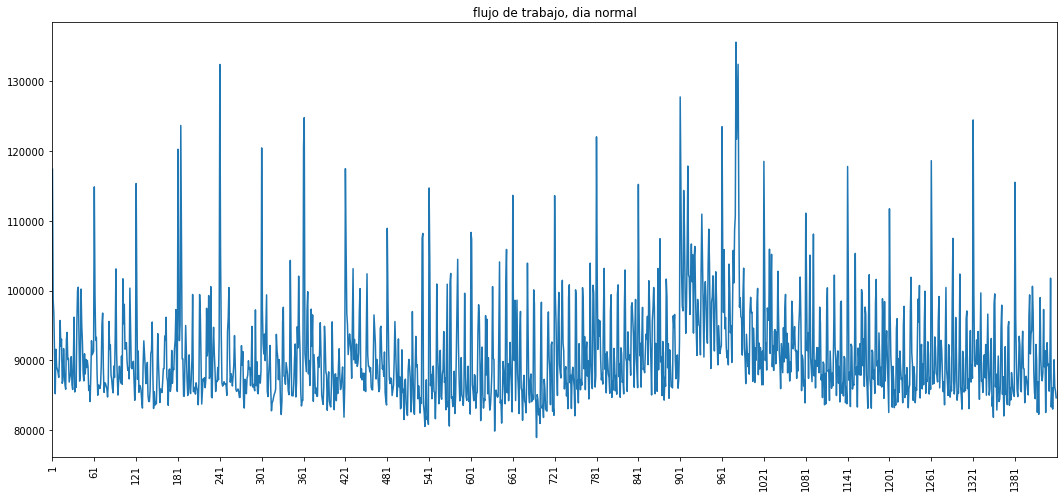

In [272]:
plt.figure(figsize=(18,8))
plt.plot(miniDia.sum())

plt.xlim(0, 1440)
plt.xticks(np.arange(0, 1440,60))
plt.xticks(rotation=90)
plt.title("flujo de trabajo, dia normal")
plt.ion()


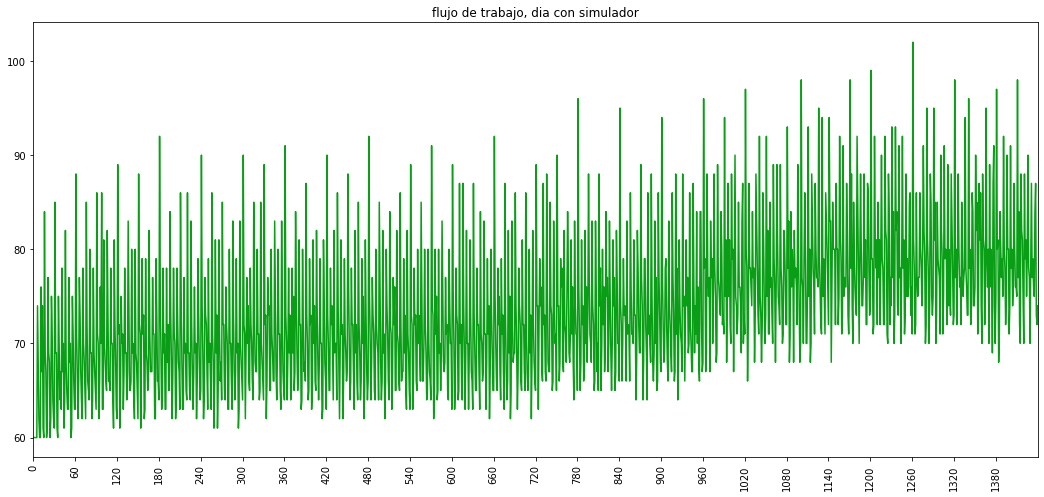

In [273]:
plt.figure(figsize=(18,8))
plt.plot(DiaMod.sum(), color ='#099e16')

plt.xlim(0, 1440)
plt.xticks(np.arange(0, 1440,60))
plt.xticks(rotation=90)
plt.title("flujo de trabajo, dia con simulador")
plt.ion()


In [274]:
dia.iloc[:3000, :].groupby('FirstTime').count()

HashFunction  Trigger  period
FirstTime                               
1                  1058     1058    1058
2                    70       70      70
3                    40       40      40
4                    24       24      24
5                    30       30      30
...                 ...      ...     ...
1399                  1        1       1
1401                  1        1       1
1413                  1        1       1
1431                  2        2       2
1440                  2        2       2

[666 rows x 3 columns]

In [282]:
DiaMod.sum()

1       60
2       60
3       60
4       60
5       60
        ..
1436    84
1437    87
1438    73
1439    72
1440    74
Length: 1440, dtype: object

# limite de movimientos y sin afectar HTTP 

In [7]:
# s cantidad de minutos que se desea desfazar los registros 
def modificar_funciones(lista, s):
    if(len(lista) == 0):
        return
    adi = np.zeros(s, dtype=int)
    aux = np.concatenate((adi, lista))
    return aux[:1440].tolist() #1440

In [19]:
a =[8,7,6,5,4,2,4,1,9]
print (modificar_funciones(a, 7))

[0 0 0 0 0 0 0 8 7]


In [55]:
def simulation(df_day):
    triggers =df_day["Trigger"].to_numpy()
    df_day.drop(['HashOwner', 'HashApp','Trigger'], axis = 1, inplace = True)
    df_day.set_index('HashFunction',inplace=True)
    limite= int(((df_day.sum().sum())/1440)) # limite segun los datos de df prueba 
    aparicion(df_day)
    df_day.insert(loc=0, column='Trigger', value=triggers)
    del(triggers)
        
    record = [0 for x in range(1,1441)]
    overl_minutes = []
    columns = [x for x in range(1,1441)]
    columns.insert(0,"Trigger")
    columns.insert(0,"HashFunction")
    df_result = pd.DataFrame(columns=columns)
    
    with tqdm(total=len(df_day), file=sys.stdout) as pbar:
        for index, row in df_day.iterrows():
            t_period = row[2:].tolist()
            
            record = np.add(record,t_period)
            overl_minutes = [i+1 for i, v in enumerate(record) if v > limite] # minutos que pasan el lim 

            
            if (row["FirstTime"] in overl_minutes and row["Trigger"] != "http"):
                cont = 1
                while (cont < 11 and row["FirstTime"] in overl_minutes) :
                    
                    record = np.subtract(record,t_period)
                    overl_minutes = [i+1 for i, v in enumerate(record) if v > limite]
                    
                    t_period = modificar_funciones(row[2:].tolist(), cont)
                   
                    record = np.add(record,t_period)
                    overl_minutes = [i+1 for i, v in enumerate(record) if v > limite]
                    cont +=1

            t_period.insert(0,row["Trigger"])
            t_period.insert(0,index)
            df_result= df_result.append(pd.DataFrame([t_period], columns=columns),ignore_index=True)
            pbar.set_description('procesando')
            pbar.update(1)
    return df_result

In [56]:
carga = pd.read_csv("invocations_per_function_md.anon.d05.csv")
miniDia = carga.iloc[:12000, :]
DiaMod = simulation(miniDia) 

procesando: 100%|████████████████████████████████████████████████████████████████| 12000/12000 [53:02<00:00,  3.77it/s]


In [57]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
#import warnings
#warnings.filterwarnings('ignore')
def hurst(serieT):
    # Create the range of lag values
    lags = range(2, 100)
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(serieT[lag:], serieT[:-lag]))) for lag in lags]
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0   

coefciente del Hurst dia normal  [0.06763638]


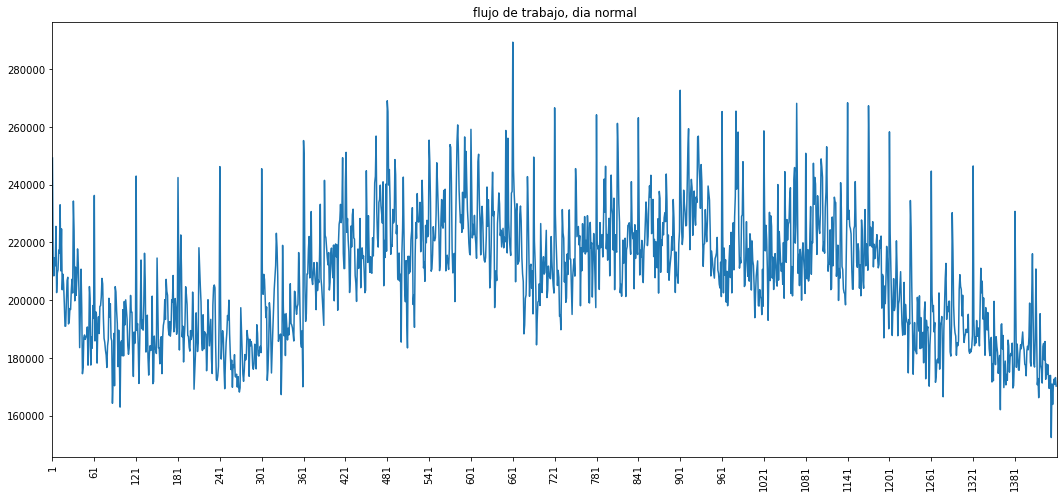

In [58]:
plt.figure(figsize=(18,8))
plt.plot(miniDia.drop(['Trigger', 'FirstTime'], axis = 1).sum())

plt.xlim(0, 1440)
plt.xticks(np.arange(0, 1440,60))
plt.xticks(rotation=90)
plt.title("flujo de trabajo, dia normal")
plt.ion()
print("coefciente del Hurst dia normal ", hurst(pd.DataFrame(miniDia.drop(['Trigger', 'FirstTime'], axis = 1).sum())))

coefciente del Hurst dia con simulador  [0.0642712]


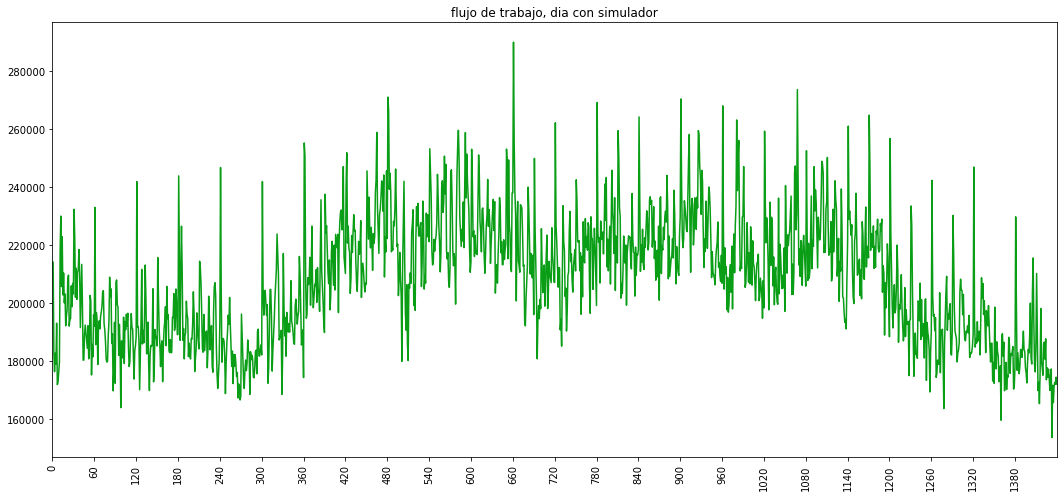

In [73]:
plt.figure(figsize=(18,8))
#DiaMod.set_index('HashFunction',inplace=True)
plt.plot(DiaMod.drop(['Trigger'], axis = 1).sum(), color ='#099e16')


plt.xlim(0, 1440)
plt.xticks(np.arange(0, 1440,60))
plt.xticks(rotation=90)
plt.title("flujo de trabajo, dia con simulador")
print("coefciente del Hurst dia con simulador ", hurst(pd.DataFrame(DiaMod.drop(['Trigger'], axis = 1).sum())))
plt.ion()

In [11]:
DiaMod.drop(['Trigger'], axis = 1).sum()

1       122072
2       107650
3       104607
4       106307
5        99572
         ...  
1436    173664
1437    162923
1438    155023
1439    167952
1440    159541
Length: 1440, dtype: object

In [112]:
miniDia.drop(['FirstTime','Trigger'], axis = 1).sum()

1       249191
2       212740
3       208401
4       214705
5       211895
         ...  
1436    170662
1437    172642
1438    170800
1439    173200
1440    170247
Length: 1440, dtype: int64

In [106]:
DiaMod.groupby("Trigger").sum().sum().sum()

299799290

In [108]:
print(299868443-299799290)

69153


In [110]:
print(299868443/1440)

208241.97430555554


In [136]:
print((299868443/1440)*0.75)

156181.48072916665


In [135]:
dia=miniDia.drop(['FirstTime','Trigger'], axis = 1).sum()
dia
dia.loc[lambda dia: dia > 208242] 

1       249191
2       212740
3       208401
4       214705
5       211895
         ...  
1321    246460
1332    211047
1381    230737
1406    216069
1411    210795
Length: 734, dtype: int64

In [44]:
df_day = pd.read_csv("invocations_per_function_md.anon.d05.csv")
triggers =df_day["Trigger"].to_numpy()
df_day.drop(['HashOwner', 'HashApp','Trigger'], axis = 1, inplace = True)
df_day.set_index('HashFunction',inplace=True)
limite= int((df_day.sum().sum())/1440) # limite segun los datos de df prueba 
aparicion(df_day)
df_day.insert(loc=0, column='Trigger', value=triggers)
del(triggers)
for index, row in df_day.iterrows():
    print(row[2:].tolist())
    print(len(row[2:].tolist()))

[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 

[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 

[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [40]:
carga = pd.read_csv("invocations_per_function_md.anon.d05.csv")
carga = carga.iloc[:3000, :]
carga.drop(['HashOwner', 'HashApp'], axis = 1, inplace = True)
carga.set_index('HashFunction',inplace=True) 
'''for index, row in carga.iterrows():
    print(row["Trigger"])
    print(row[1:].to_numpy())
        '''

carga.groupby("Trigger").sum()


1      2      3      4      5      6      7      8      9  \
Trigger                                                                        
event           8329   9435   9864   6019   6082   8896   7626   7759   7368   
http           93361  77341  73148  75835  71408  73182  73506  73356  73209   
orchestration   3896   5303   6004   1259    209    136    112    200     96   
others            67     14      7     39      3     10     17      5      6   
queue           9862   5510   6126   6441   6200   7941   6530   6094   6427   
storage          670    561    911    777    652    632    629    646    579   
timer           1222    610    639    648    657    801    661    633    647   

                  10  ...   1431   1432   1433   1434   1435   1436   1437  \
Trigger               ...                                                    
event           7264  ...   7306   6594   7039   6623   6959   7410   7268   
http           73038  ...  70231  73722  68760  72657  69518  71941  73434   
orchestration    169  ...   4362  11434    396    124    163    165    184   
others            16  ...     16     15      2      3     20     43      3   
queue           5759  ...   5325   8670   5808   5441   5019   5212   7889   
storage          576  ...    562    715    633    612    598    632    643   
timer            730  ...    836    639    670    619    734    787    665   

                1438   1439   1440  
Trigger                             
event           7027   6958   7289  
http           70447  72133  70281  
orchestration    131    171    116  
others            14      5      6  
queue           7273   5192   5635  
storage          651    529    660  
timer            646    659    643  

[7 rows x 1440 columns]

In [44]:
print(carga.groupby("Trigger").sum().max())

print(carga.groupby("Trigger").sum().max() - carga.groupby("Trigger").sum().min())



1       93361
2       77341
3       73148
4       75835
5       71408
        ...  
1436    71941
1437    73434
1438    70447
1439    72133
1440    70281
Length: 1440, dtype: int64
1       93294
2       77327
3       73141
4       75796
5       71405
        ...  
1436    71898
1437    73431
1438    70433
1439    72128
1440    70275
Length: 1440, dtype: int64


In [38]:
carga.groupby("Trigger").sum().sum(axis = 1)

Trigger
event              8844621
http             106320899
orchestration      2831811
others               49702
queue             10899829
storage             859965
timer              1001235
dtype: int64

In [34]:
carga.drop(["Trigger"], axis = 1).sum()

130808062

In [142]:
record = [0 for x in range(1,1441)]
t_period = period_list(66, 98)
#record = np.add(record,t_period)
print(len(record))
print(len(t_period))

print(len(record))

1440
32
1440


In [107]:
first = [1,0,3,0,1]
second = [0,1,0,0,1]
print(np.add(first, second))
print(np.subtract(first, second))

[1 1 3 0 2]
[ 1 -1  3  0  0]


In [74]:
columns = [x for x in range(1,1441)]
columns.insert(0,"HashFunction")

df = pd.DataFrame(columns=columns)
print(df)

Empty DataFrame
Columns: [HashFunction, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
Index: []

[0 rows x 1441 columns]


In [75]:
fila=  [1 for x in range(1,1441)]
fila.insert(0,"154dasdsafgasffsd5ffsdfs4")
print(len(fila))

1441


In [102]:
df = df.append(pd.DataFrame([fila], columns=columns),ignore_index=True)

In [104]:
df

HashFunction  1  2  3  4  5  6  7  8  9  ... 1431 1432 1433  \
0  154dasdsafgasffsd5ffsdfs4  1  1  1  1  1  1  1  1  1  ...    1    1    1   

  1434 1435 1436 1437 1438 1439 1440  
0    1    1    1    1    1    1    1  

[1 rows x 1441 columns]

In [33]:
lista = period_list(5, 1)
print(lista)

[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 

In [36]:
Posx = [i+1 for i, e in enumerate(lista) if e > 1]

In [37]:
print(Posx)

[]


In [5]:
print([1 if x % 5 == 0 else 0 for x in range(1,43)])




[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
